In [7]:
# here is how we activate an environment in our current directory
import Pkg; Pkg.activate(@__DIR__);

# instantate this environment (download packages if you haven't)
Pkg.instantiate();

import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 

  Activating project at `~/Downloads/MSR Academics/zoe2_optimal_controller/julia`


In [8]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

In [9]:
function dynamics_bicycle(params::NamedTuple, x::Vector, u::Vector)
    x_pos, y_pos, ψ, θf, θr = x[1:5]  # States
    ω_fl, ω_fr, ω_rl, ω_rr = u[1:4]  # Inputs
    r, L, B = params.r, params.L, params.B
    ϵ = 1e-6

    v_f = r*(ω_fl+ω_fr)/2
    v_r = r*(ω_rl+ω_rr)/2
    v_b = (1/2)*((v_f/cos(θr))+(v_r/cos(θf)))*√(cos(θf)*cos(θr)*cos(θf+θr)+(1/4)*sin(θf+θr)^2)

    ẋ = v_b*cos(ψ)
    ẏ = v_b*sin(ψ)
    ψ̇ = (sin(θf+θr)/(2*L))*((v_f/cos(θr))+(v_r/cos(θf)))
    θḟ = r*(ω_fr-ω_fl)/B
    θṙ = r*(ω_rl-ω_rr)/B

    xdot = [ẋ; ẏ; ψ̇; θḟ; θṙ]
    # @show v_b, θr, θf
    # @show xdot
    return xdot;
end

dynamics_bicycle (generic function with 1 method)

In [10]:
function rk4(params::NamedTuple, model, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*model(params, x, u)
    k2 = dt*model(params, x + k1/2, u)
    k3 = dt*model(params, x + k2/2, u)
    k4 = dt*model(params, x + k3, u)

    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 2 methods)

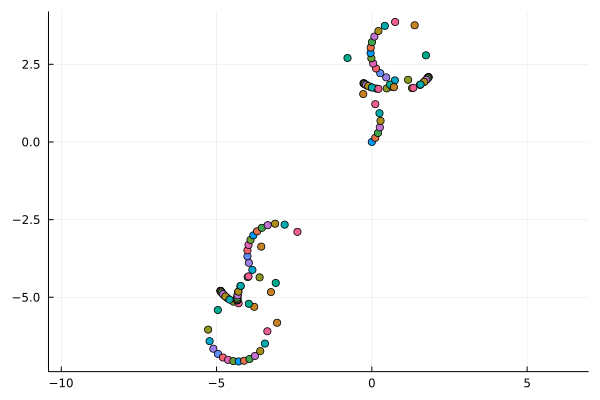

In [13]:
params = (r = 0.325, L = 1.91, B = 1.64)
u = [1.0, 2.0, 1.0, 2.0]

x0 = [0,0,pi/4, pi/4, pi/4]
nx = 5
N = 120
dt = 0.05
t_vec = 0:dt:((N-1)*dt)

X = [zeros(nx) for i = 1:N]
X[1] = x0
for i = 1:(N-1)
    X[i+1] = rk4(params, dynamics_bicycle, X[i], u, dt)
    if X[i+1][3] >= 2*pi
        X[i+1][3] %= 2*pi
    elseif X[i+1][3] < 0
        X[i+1][3] += 2*pi
    end

    if X[i+1][4] >= 2*pi
        X[i+1][4] %= 2*pi
    elseif X[i+1][4] < 0
        X[i+1][4] += 2*pi
    end

    if X[i+1][5] >= 2*pi
        X[i+1][5] %= 2*pi
    elseif X[i+1][5] < 0
        X[i+1][5] += 2*pi
    end
end

X = hcat(X...)
x = X[1,:]
y = X[2,:]
# print(y[2]-y[1])
# result = fit(Circle,x,y)
# @show coef(result)
# @show coefnames(result)
# @show rss(result)

display(scatter(X[1,:]', X[2,:]', legend=false, aspect_ratio=:equal))